<a href="https://colab.research.google.com/github/fcolombo7/AN2DL-2020/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation using a **U-Net** like neural network

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os
from zipfile import ZipFile
import sys
sys.path.append('/content/drive/MyDrive/ANN_project2/starting_kit')

from prepare_submission import *
from read_mask_example import * 
from decode_rle_example import *

import tensorflow as tf
import numpy as np

In [64]:
# Set the seed for random operations. 
SEED = 1234
tf.random.set_seed(SEED)

In [65]:
#Definitions of constants
apply_data_augmentation = True
IMG_W, IMG_H = 2048, 1536 

## Load the dataset

In [66]:
if not os.path.exists('Development_Dataset'):
  with ZipFile('./drive/MyDrive/ANN_project2/dataset.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()
print('The dataset is loaded.')

The dataset is loaded.


In [67]:
cwd = os.getcwd()

Define the `ImageDataGenerator`

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [69]:
from PIL import Image
from sklearn.model_selection import train_test_split

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir_list, which_subset, seed=1234, valid_perc=0.2, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    
    self.subset_filenames=[]
    for dataset_dir in dataset_dir_list:
      #get all the filenames
      path = dataset_dir
      #single filename list
      l = os.listdir(os.path.join(path, 'Images'))
      l = list(map(lambda x: x[:-4], l))
      #print(l)
      #get the train test split
      pos_train, pos_valid = train_test_split(range(len(l)), test_size = valid_perc, random_state=seed)
      sel_pos= pos_train if which_subset == 'training' else pos_valid
      for pos in sel_pos:
        self.subset_filenames.append((dataset_dir, l[pos]))

    self.which_subset = which_subset
    self.dataset_dir_list = dataset_dir_list
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(curr_filename[0], 'Images', curr_filename[1] + '.jpg'))
    #mask = Image.open(os.path.join(curr_filename[0], 'Masks', curr_filename[1] + '.png'))
    

    # Resize image and mask
    img = img.resize(self.out_shape)
    #mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    mask_arr = read_rgb_mask(os.path.join(curr_filename[0], 'Masks', curr_filename[1] + '.png'), out_shape=self.out_shape)
    
    img_arr = np.array(img)
    #mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [70]:
from tensorflow.keras.applications.vgg16 import preprocess_input 
dir1 = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip', 'Haricot')
dir2 = os.path.join(cwd, 'Development_Dataset', 'Training', 'Bipbip', 'Mais')


dataset = CustomDataset([dir1, dir2], 
                        'training',
                        seed = SEED,
                        valid_perc=0.2,
                        img_generator=img_data_gen,
                        mask_generator=mask_data_gen,
                        out_shape=[IMG_W, IMG_H],
                        preprocessing_function=None)

dataset_valid = CustomDataset([dir1, dir2], 
                        'validation',
                        seed = SEED,
                        valid_perc=0.2,
                        img_generator=img_data_gen,
                        mask_generator=mask_data_gen,
                        out_shape=[IMG_W, IMG_H],
                        preprocessing_function=None)

In [71]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([IMG_H, IMG_W, 3], [IMG_H, IMG_W, 1]))

train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([IMG_H, IMG_W, 3], [IMG_H, IMG_W, 1]))

valid_dataset = valid_dataset.batch(32)
valid_dataset = valid_dataset.repeat()

### Visualization of some samples
Test the setup and check if the generator works as expected.

In [72]:
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


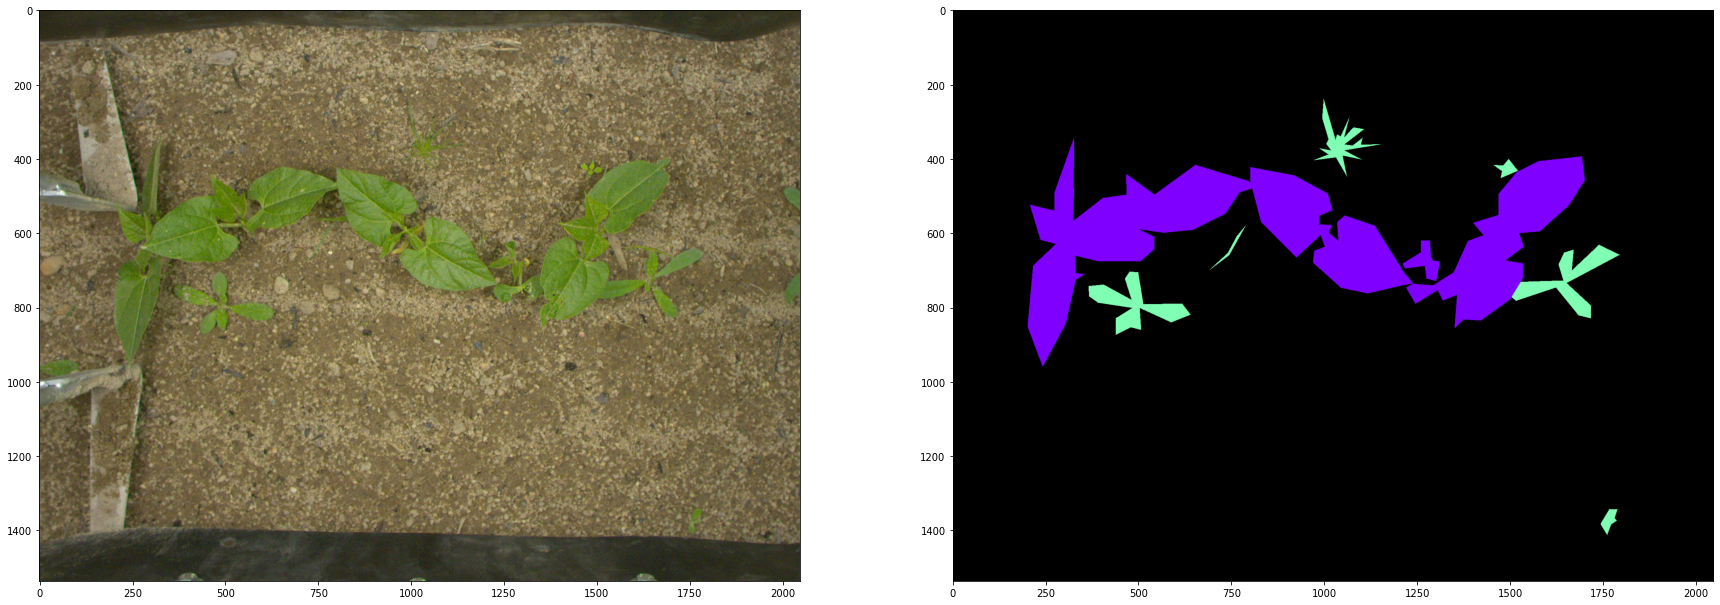

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(30,20))

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## CNN design

Taking inspiration from [this implementation](https://www.kaggle.com/krishanudb/keras-based-unet-model-construction-tutorial/data).
Here the definition of some helper function used to build the *U-Net like* network.

In [74]:
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Input
from keras.layers import MaxPooling2D

Downsampling block:

In [75]:
def DownsamplingBlock(x, #input layer
                 level, #depth level
                 filters, #filter_size i.e. depth of the conv layer
                 kernel_size = (3, 3),
                 num_convs = 2,
                 conv_strides = (1, 1),
                 activation = 'relu',
                 batch_norm = False, #non ho idea di cosa faccia
                 pool_size = (2, 2),
                 pool_strides = (2, 2),
                 regularizer = None,
                 regularizer_param = 0.001):
  
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None

    for i in range(num_convs):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size, 
                   strides=conv_strides, 
                   padding='same', 
                   kernel_regularizer=reg, 
                   bias_regularizer=reg, 
                   name = 'downsampling_' + str(level) + '_conv_' + str(i))(x)
        if batch_norm:
            x = BatchNormalization(name = 'downsampling_' + str(level) + '_batchnorm_' + str(i))(x)
        x = Activation(activation, name = 'downsampling_' + str(level) + '_activation_' + str(i))(x)
    skip = x
    x = MaxPooling2D(pool_size=pool_size, strides=pool_strides)(x)
    return x, skip

Upsampling block:

In [76]:
def UpsamplingBlock(x, # input layer
               level, # level of the net
               skip, # skip connection for concatenation
               filters, # depth of the convolutional layer
               kernel_size = (3, 3),
               num_convs = 2,
               conv_strides = (1,1),
               activation = 'relu',
               batch_norm = False,
               conv_transpose = True,
               upsampling_size = (2,2) ,
               upsampling_strides = (2,2),
               regularizer = None,
               regularizer_param = 0.001):
  
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    
    x = Conv2DTranspose(filters=filters, 
                        kernel_size=upsampling_size, 
                        strides=upsampling_strides, 
                        name = 'upsampling_' + str(level) + '_conv_trans_' + str(level))(x)
    x = Concatenate()([x, skip])
    for i in range(num_convs):
        x = Conv2D(filters=filters, 
                   kernel_size=kernel_size, 
                   strides=(1, 1),
                   padding='same',
                   kernel_regularizer=reg,
                   bias_regularizer=reg,
                   name = 'upsampling_' + str(level) + '_conv_' + str(i))(x)
        if batch_norm:
            x = BatchNormalization(name = 'upsampling_' + str(level) + '_batchnorm_' + str(i))(x)
        x = Activation(activation, name = 'upsampling_' + str(level) + '_activation_' + str(i))(x)
    return x


Bottleneck (connectior between Encoder and Decoder):

In [77]:
# there is another version called bootleneck dilatated.. we start with the simpler one    
def BottleneckBlock(x,
               filters,
               kernel_size = (3, 3),
               num_convs = 2,
               conv_strides= (1,1),
               activation = 'relu',
               batch_norm = False,
               #pool_size = (2, 2),
               #pool_strides = (1,1),
               regularizer = None, 
               regularizer_param = 0.001):
    if regularizer is not None:
        if regularizer == 'l2':
            reg = regularizers.l2(regularizer_param)
        elif regularizer == 'l1':
            reg = regularizers.l1(regularizer_param)
    else:
        reg = None
    for i in range(num_convs):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides= conv_strides,
                   padding='same',
                   kernel_regularizer=reg, 
                   bias_regularizer=reg,
                   name = 'bottleneck_' + str(i))(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
    return x

Last, the model builder:

In [84]:
def get_unet(num_classes,
             num_levels,
             input_shape,
             num_conv_layers_per_block = 2,
             num_bottleneck = 2, #number of convolutional layer in between encoder and decoder
             filter_depth_start = 16,
             batch_norm = False,
             kernel_size = (3, 3),
             regularizer = None,
             regularizer_param = 0.001):
  
    inputs = Input((input_shape))
    x = inputs
    skips = []
    for i in range(num_levels):
        x, skip = DownsamplingBlock(x, i,
                               filter_depth_start * (2 ** i), 
                               kernel_size, 
                               num_conv_layers_per_block,
                               batch_norm = batch_norm,
                               regularizer= regularizer,
                               regularizer_param=regularizer_param)
        skips.append(skip)

    x = BottleneckBlock(x,
                   filter_depth_start * (2 ** num_levels),
                   kernel_size,
                   num_bottleneck,
                   batch_norm=batch_norm,
                   regularizer=regularizer, 
                   regularizer_param=regularizer_param)
    
    for j in range(num_levels):
        x = UpsamplingBlock(x, j,
                            skips[num_levels - j - 1],
                            filter_depth_start * (2 ** (num_levels - j - 1)),
                            kernel_size,
                            num_conv_layers_per_block,
                            batch_norm=batch_norm, 
                            regularizer= regularizer,
                            regularizer_param=regularizer_param)
        
    outputs = Conv2D(filters=num_classes,
                     kernel_size=(1,1), 
                     strides=(1,1), 
                     padding='same', 
                     activation='softmax', 
                     name = 'output_softmax')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    return model



Build the **U-Net** model and print its summary:

In [85]:
model = get_unet(3, 4, (IMG_H, IMG_W, 3), filter_depth_start=64)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1536, 2048,  0                                            
__________________________________________________________________________________________________
downsampling_0_conv_0 (Conv2D)  (None, 1536, 2048, 6 1792        input_19[0][0]                   
__________________________________________________________________________________________________
downsampling_0_activation_0 (Ac (None, 1536, 2048, 6 0           downsampling_0_conv_0[0][0]      
__________________________________________________________________________________________________
downsampling_0_conv_1 (Conv2D)  (None, 1536, 2048, 6 36928       downsampling_0_activation_0[0][0]
_______________________________________________________________________________________

--- 
codice da guardare ancora

In [ ]:
model.compile(optimizer='adam', loss=jaccard_distance_loss, metrics=[dice_coef])
model.summary()

In [ ]:
#questa funzione la rifarei come le nostre precedenti con le varie callback
def model_train(model, x, y, epochs, num_test, early_stopper, patience_lr, model_name):
    num_data = x.shape[0]
    num_train = num_data - num_test
    early_stopper = EarlyStopping(patience=early_stopper, verbose=1)
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor = 0.75, patience = patience_lr, verbose=1)
    checkpointer = ModelCheckpoint(model_name + '.h5', verbose=1, save_best_only=True)
    checkpointer_train = ModelCheckpoint(model_name + 'best_train.h5', monitor='loss', verbose=1, save_best_only=True)
    results = model.fit(x[0:num_train], y[0:num_train], validation_data=(x[num_train:], y[num_train:]), batch_size=5, epochs=epochs, callbacks=[early_stopper, checkpointer, checkpointer_train, reduce_learning_rate])
    return model, results